In [1]:

from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import numpy as np
import zipfile
import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Open url for scraping. All data sources are stored within a table. All target data files have the
# same naming scheme, we will take advantage of this

In [3]:

url = 'http://www.fueleconomy.gov/feg/download.shtml'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'lxml')


reg = 'epadata/\d{2}data.zip' ##luckily our target has a unique identifier for href
suf = 'http://www.fueleconomy.gov/feg/'

In [4]:
# Find target data sources within html page

In [5]:
links = soup.find_all('a')
zlist = []
for tag in links:
    link = tag.get('href',None)
    if link is not None:
        if re.match(reg, link):
            zlist.append(link)

In [6]:
# Download data to current working directory. These files are zipped. Unzip files.

In [7]:
filelst = []
for x in zlist:
    url = suf+x
    localfn = url.split('/')[-1]
    yearno = int(localfn[:2])
    if yearno < 50 and yearno > 00:
        r = requests.get(url, stream=True)
        with open(localfn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        zip_ref = zipfile.ZipFile(localfn, 'r')
        lcl = "dldir"+localfn
        filelst.append(lcl)
        zip_ref.extractall(lcl)
        zip_ref.close()
       
        


In [8]:
# create directory to store data

In [9]:
datdir = "shibe_data"
if not os.path.exists(datdir):
    os.makedirs(datdir)

In [10]:
# extract downloaded data to single directory. Rename files so that they have uniform names

In [11]:
reg = "(.xlsx|.xls|.csv)$"
for item in filelst:
    for filename in os.listdir(item):
        curname =  item + "\\" + filename 
        
        
        m = re.search(reg, filename)
        if m:
            newname = datdir + "\\" + item[:-4] + m.group(0)
            os.rename(curname, newname)


In [12]:
# clean up files and directories created while scraping data

In [13]:

lst = os.listdir(os.getcwd())
for x in lst:
    m = re.search(".zip$", x)
    if m:
        n = re.search("^dldir",x)
        if n:
            shutil.rmtree(x)
        else:
            os.remove(x)


In [14]:
# Reads data files into Pandas Dataframes according to file type (.csv .xlx .xlsx). The df are stored in a temporary dict 
# according to their respective years. The original zip file from the EPA site does not give year in YYYY format, so we have 
# chosen not to use the YYYY format until this point where it becomes necessary and after we have gleaned out only the years 
# prefixed by "20-"
# Some lines of the original data files are formed incorrectly. Adding the option "error_bad_lines=False" skips these lines

In [15]:
%%capture
datfiles = os.listdir(datdir)
pdfiles = {}
for x in datfiles:
    y = re.search("[0-9]{2}",x)
    year = "20" + y.group(0)
    cs = re.search(".csv$", x)
    if cs:
        newp = pd.read_csv(datdir + "\\" + x, error_bad_lines=False)
    else:
        newp = pd.read_excel(datdir + "\\" + x)
        
    pdfiles[year] = newp
    

In [16]:
# Went through all the data files from 2001-2018 and found all the persisting variables and listed their aliases in a dict, vars

In [17]:
varss = {}
varss['Class'] = ['CLASS','Carline Class Desc', 'Class']
varss['Manufacturer'] = ['MFR', 'Manufacturer', 'Mfr Name', 'Mfr Name ']
varss['carline name'] = ['CAR LINE', 'Carline', 'carline name']
varss['cmb'] = ['COMB MPG (GUIDE)', 'Comb FE (Guide) - Conventional Fuel', 'cmb']
varss['cty'] = ['CITY MPG (GUIDE)', 'City FE (Guide) - Conventional Fuel', 'cty']
varss['cyl'] = ['# Cyl', 'NUMB CYL', 'cyl']
varss['displ'] = ['DISPLACEMENT', 'Eng Displ', 'displ']
varss['fcost'] = ['ANL FL CST', 'Annual Fuel1 Cost - Conventional Fuel', 'fcost']
varss['fl'] = ['FUEL TYPE', 'Fuel Usage Desc - Conventional Fuel', 'fl']
varss['hwy'] = ['HWY MPG (GUIDE)', 'Hwy FE (Guide) - Conventional Fuel', 'hwy']
varss['trans'] = ['TRANS', 'Trans as listed in FE Guide (derived from col AA thru AF)', 'Trans in FE Guide (MFR entered for data entered after May 13 2011)', 'Transmission', 'trans']
varss['ucmb'] = ['Comb Unadj FE - Conventional Fuel', 'UNRND COMP (EPA)', 'ucmb']
varss['ucty'] = ['City Unadj FE - Conventional Fuel', 'UNRND CITY (EPA)', 'ucty']
varss['uhwy'] = ['Hwy Unadj FE - Conventional Fuel', 'UNRND HWY (EPA)', 'uhwy']
varss['drv'] = ['DRIVE SYS', 'Drive Sys', 'drv']

In [18]:
# Finds all the column names which are included inside of the shared variable map and replaces the dataframe 
# with only those columns. Renames them to the shared variable map's key names, so that column names can be 
# standardized. The columns are reordered before replacing the dataframes inside the original master map of df

In [19]:
varlst = list(varss.keys())
yearlst = list(pdfiles.keys())


for z in yearlst:
    curpd = pdfiles[z]
    cols = list(curpd.columns.values)
    checklst = []
    rename = []
    
    for x in cols:
        for y in varlst:
            if x in varss[y]:
                checklst.append(x)
                rename.append(y)
    curpd = curpd[checklst]
    curpd.columns = rename
    curpd = curpd[varlst]
    curpd['year'] = z
    pdfiles[z] = curpd


In [20]:
# Finds all car classes from over the years. Aliases for car classes are 
# combined in the carclass dict. Some types (small SUV and standard SUV are 
# combined since they were originally the same category in previous years).

In [21]:
cartypes = []
for x in yearlst:
    curpd = pdfiles[x]
    temp = set(curpd['Class'].values)
    cartypes.extend(list(temp))
cartypes = list(set(cartypes))

In [22]:
carclass = {}

carclass['COM'] = ['COMPACT CARS','Compact Cars','SUBCOMPACT CARS','Subcompact Cars','MINICOMPACT CARS','Minicompact Cars']
carclass['LAR'] = ['LARGE CARS','Large Cars']
carclass['MID'] = [ 'MIDSIZE CARS','Midsize Cars']
carclass['MINIV'] = ['MINIVAN - 2WD','Special Purpose Vehicle, minivan 2WD','SPEC PURP VEH - MINIVAN - 2WD','SPEC PURP VEH - MINIVAN - 4WD','Special Purpose Vehicle, minivan 4WD','MINIVAN - 4WD']
carclass['PU'] = ['SMALL PICKUP TRUCKS 4WD','Small Pick-up Trucks 4WD', 'Small Pick-up Trucks 2WD','STANDARD PICKUP TRUCKS 2WD','Standard Pick-up Trucks 2WD','Standard Pick-up Trucks 4WD']

carclass['SW'] = ['MIDSIZE STATION WAGONS','SMALL STATION WAGONS','Small Station Wagons','Midsize Station Wagons']
carclass['SUV'] = ['SPEC PURP VEH - S.U.V. - 4WD','S.U.V. - 4WD','Small SUV 4WD','Special Purpose Vehicle, SUV 4WD','Standard SUV 4WD','SPEC PURP VEH - S.U.V. - 2WD','S.U.V. - 2WD','Small SUV 2WD','Special Purpose Vehicle, SUV 2WD','Standard SUV 2WD']

carclass['2S'] = ['TWO SEATERS','Two Seaters']


In [23]:
pig = sns.light_palette("green",18)
piv = sns.light_palette("purple",18)
pir= sns.light_palette("red",18)


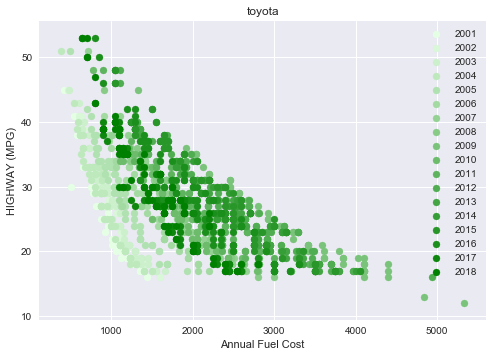

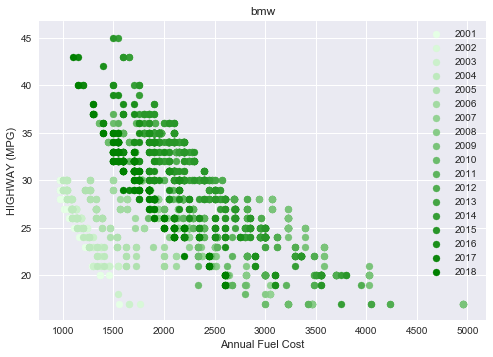

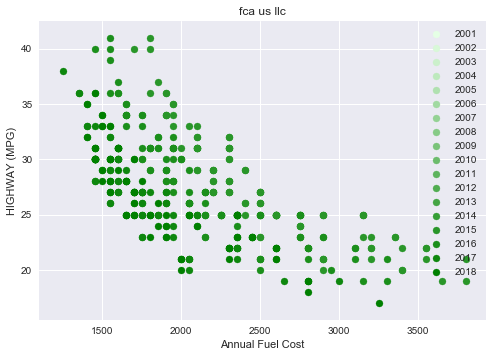

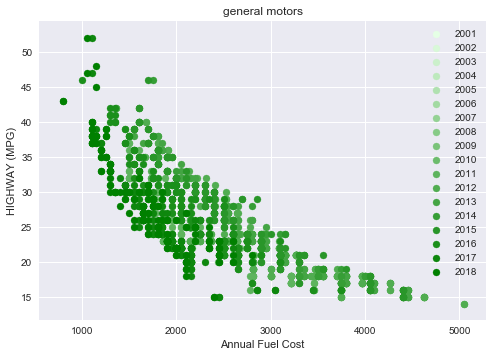

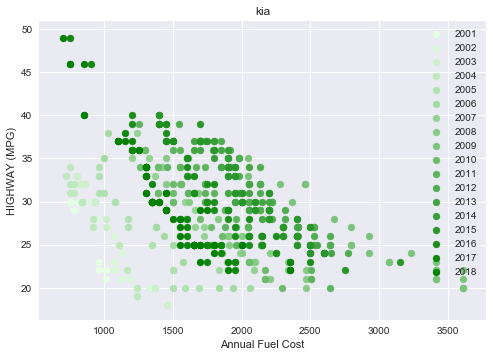

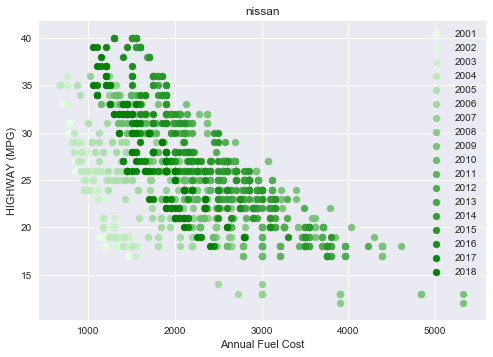

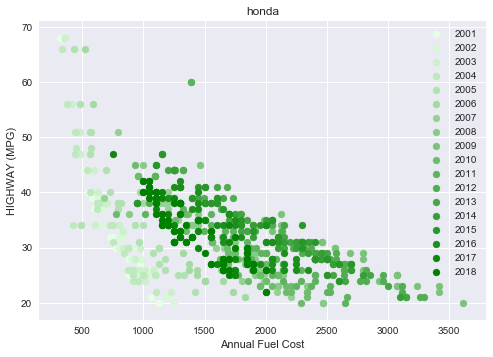

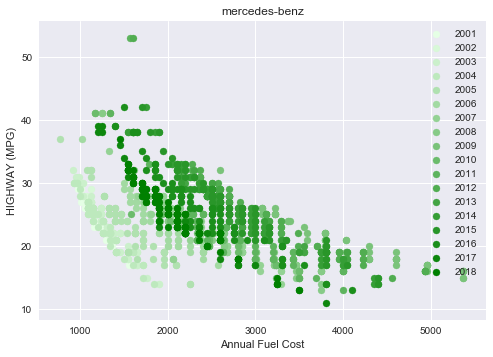

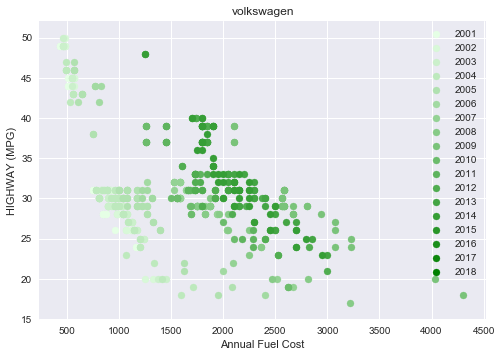

In [31]:

for brands in manufacturer:
    fig = plt.figure()
    plt.title(brands)
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('HIGHWAY (MPG)')
    avg = []
    avg_2 = []
    for x in yearlst:
        curpd = pdfiles[x]
        th = curpd[curpd['Manufacturer'].str.lower() == brands]
        avg.append(th['fcost'].mean())
        avg_2.append(th['hwy'].mean())
        i = th['fcost']
        j = th['hwy']
        plt.scatter(i,j, color = pig[int(x)-2001],label = x)
        
    plt.legend()
    plt.show()

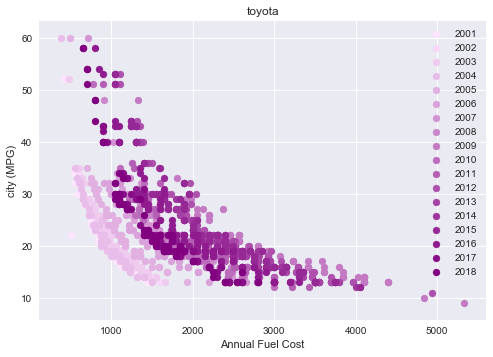

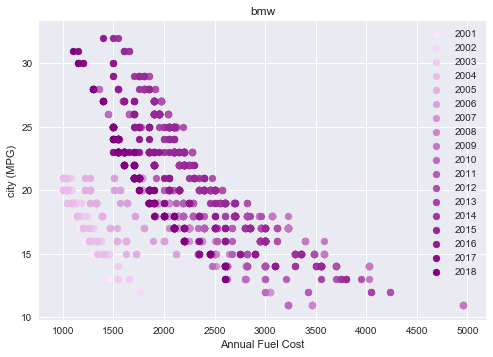

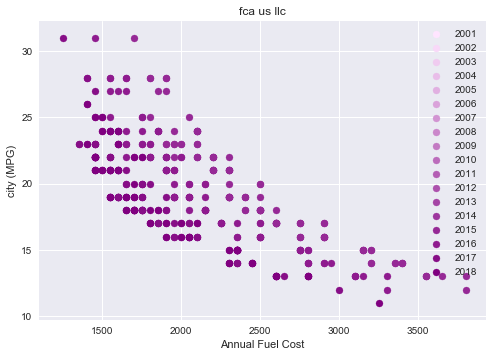

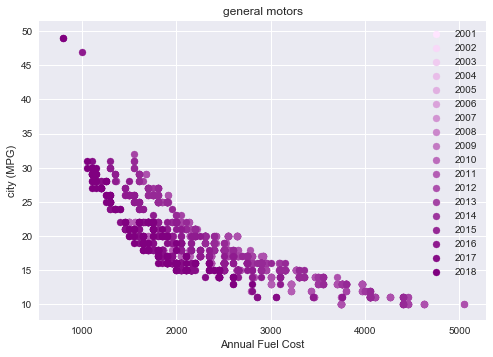

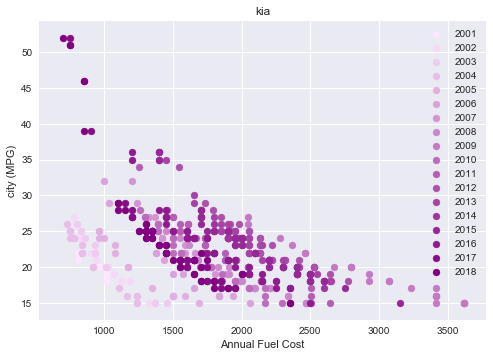

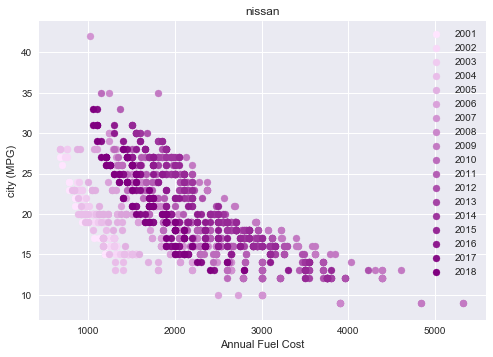

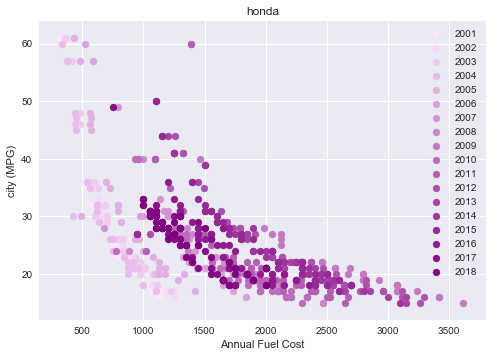

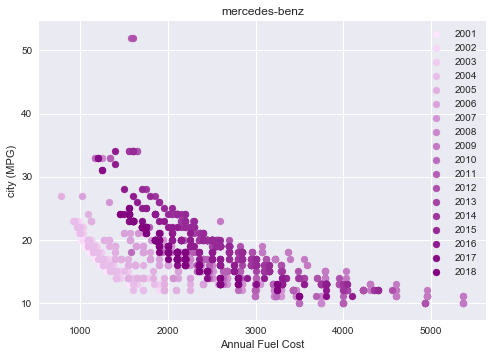

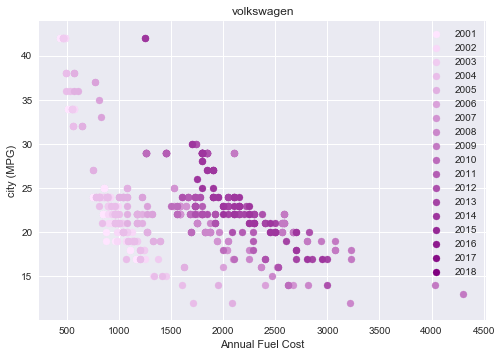

In [32]:

for brands in manufacturer:
    fig = plt.figure()
    plt.title(brands)
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('city (MPG)')
    for x in yearlst:
        curpd = pdfiles[x]
        th = curpd[curpd['Manufacturer'].str.lower() == brands]
        i = th['fcost']
        j = th['cty']
        plt.scatter(i,j, color = piv[int(x)-2001],label = x)
        
    plt.legend()
    plt.show()

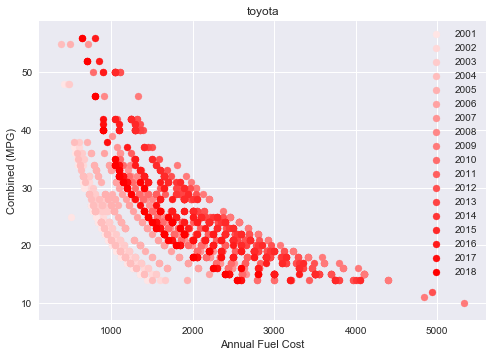

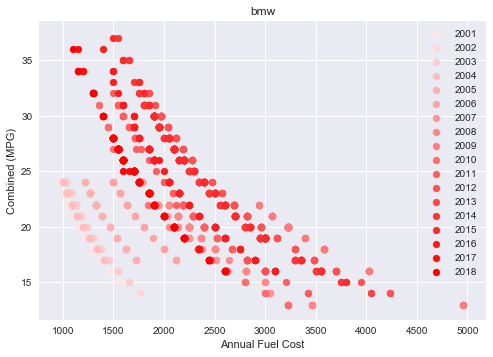

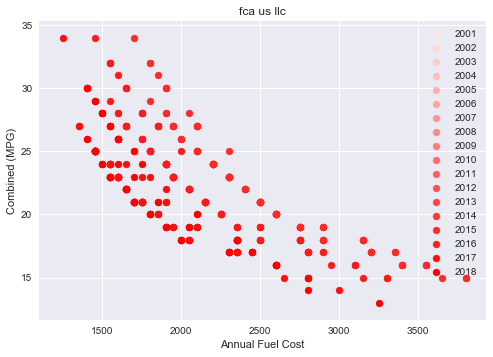

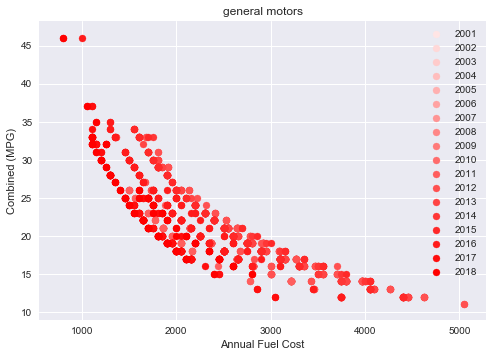

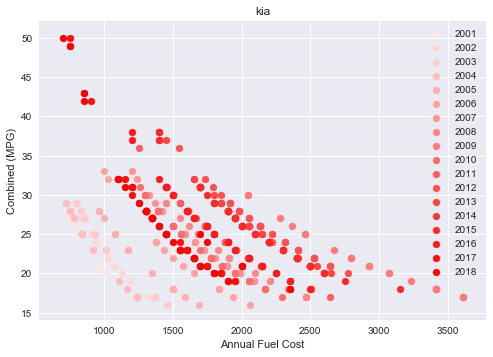

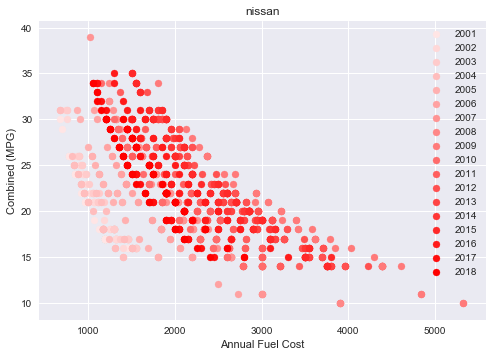

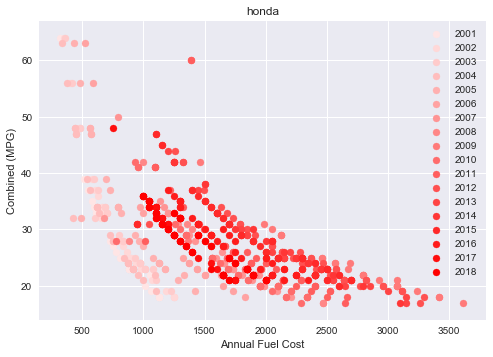

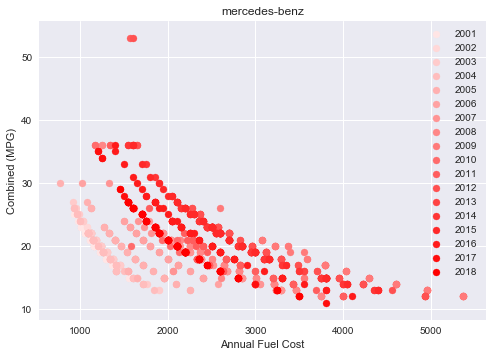

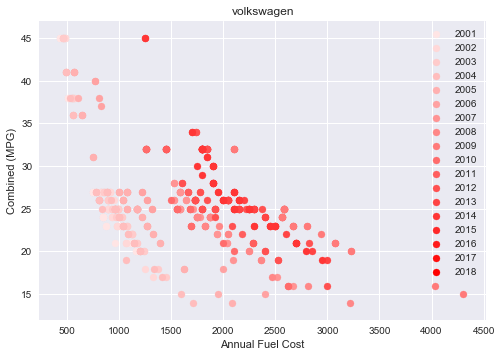

In [33]:

for brands in manufacturer:
    fig = plt.figure()
    plt.title(brands)
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('Combined (MPG)')
    for x in yearlst:
        curpd = pdfiles[x]
        th = curpd[curpd['Manufacturer'].str.lower() == brands]
        i = th['fcost']
        j = th['cmb']
        plt.scatter(i,j, color = pir[int(x)-2001],label = x)
        
    plt.legend()
    plt.show()

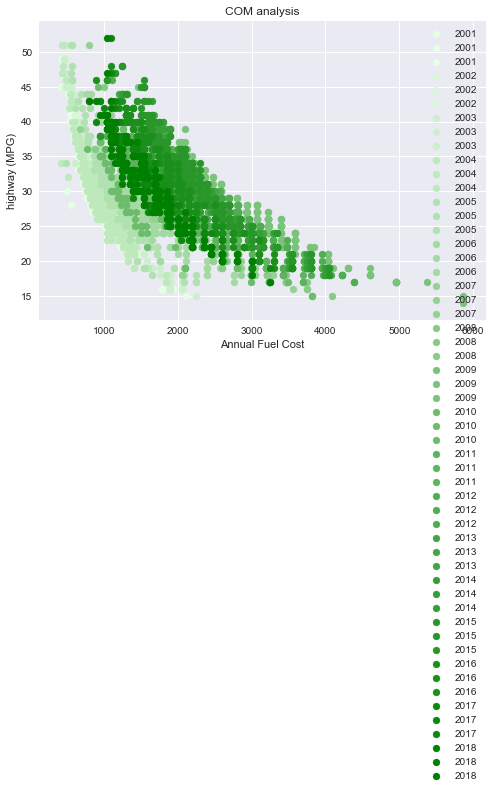

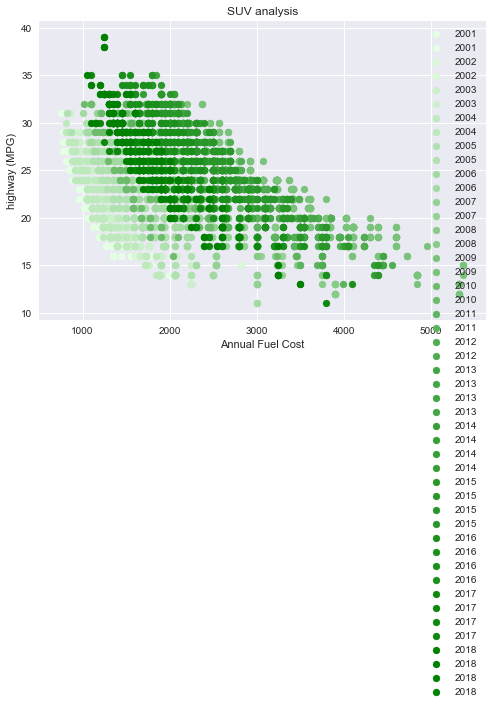

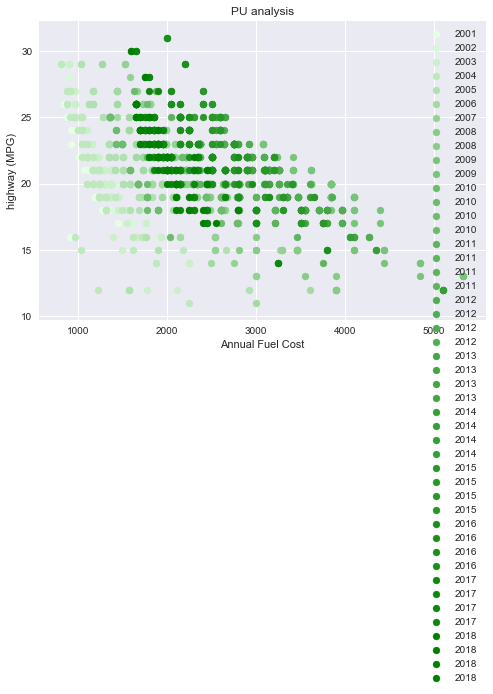

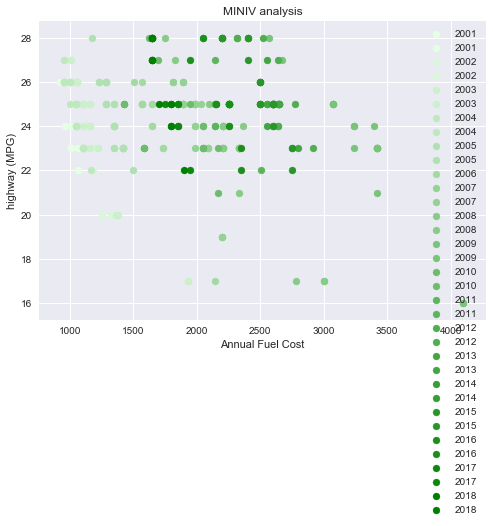

In [35]:
for t in classs:
    fig = plt.figure()
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('highway (MPG)')
    plt.title(t + ' analysis')
    for x in yearlst:
        curpd = pdfiles[x]
        s = set(curpd['Class'].values)
        for y in s:
            if y in carclass[t]:
                th = curpd[curpd['Class'] == y]
                i = th['fcost']
                j = th['hwy']
                plt.scatter(i,j, color = pig[int(x)-2001],label = x)

    plt.legend()
    plt.show()

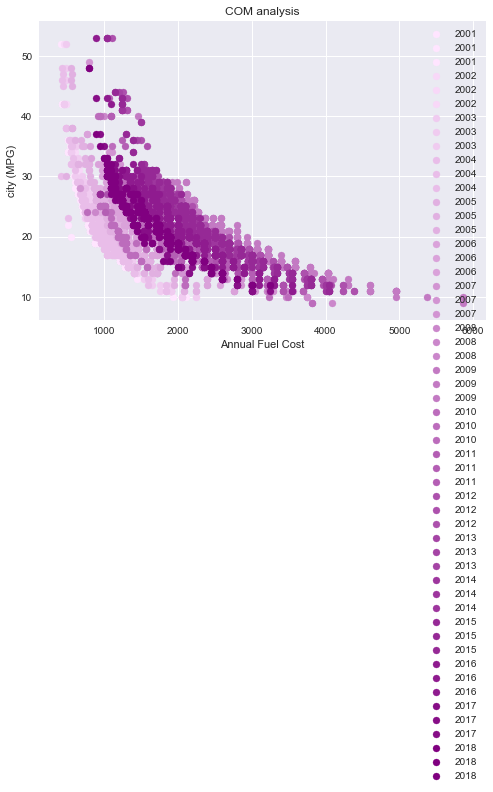

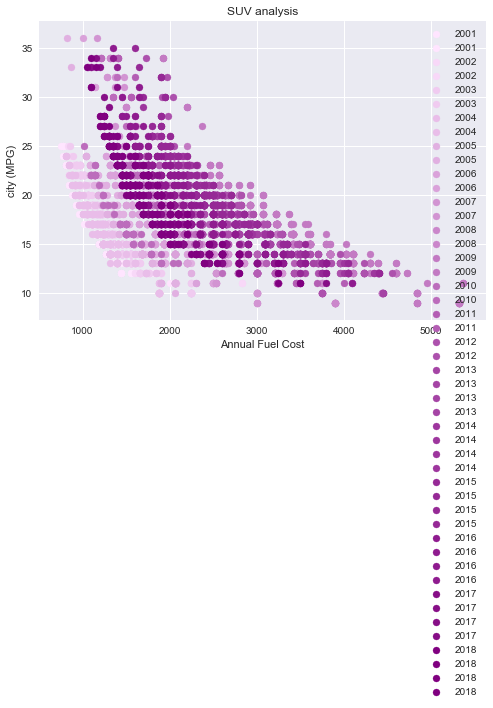

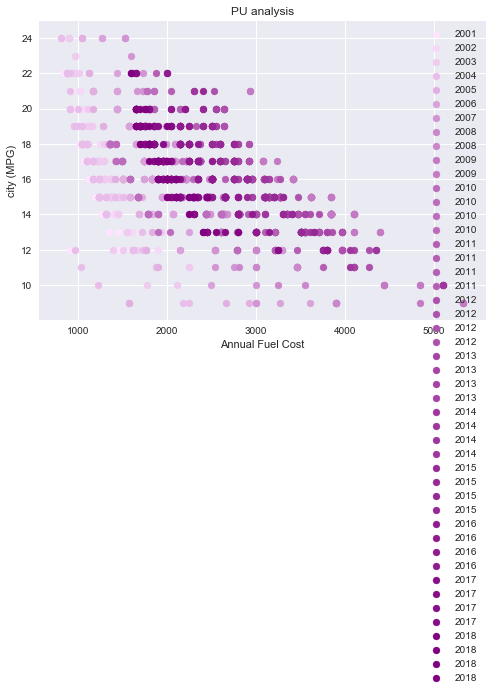

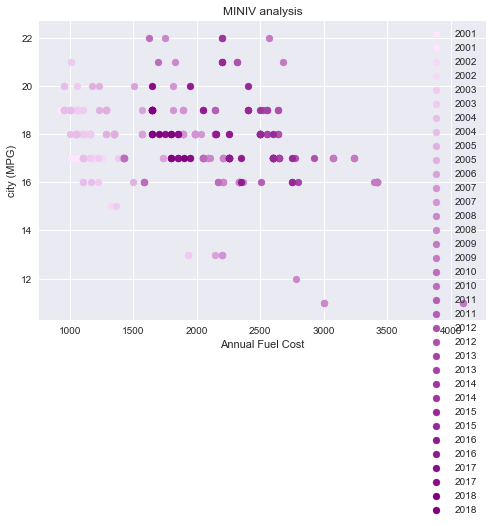

In [36]:
for t in classs:
    fig = plt.figure()
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('city (MPG)')
    plt.title(t + ' analysis')
    for x in yearlst:
        curpd = pdfiles[x]
        s = set(curpd['Class'].values)
        for y in s:
            if y in carclass[t]:
                th = curpd[curpd['Class'] == y]
                i = th['fcost']
                j = th['cty']
                plt.scatter(i,j, color = piv[int(x)-2001],label = x)

    plt.legend()
    plt.show()

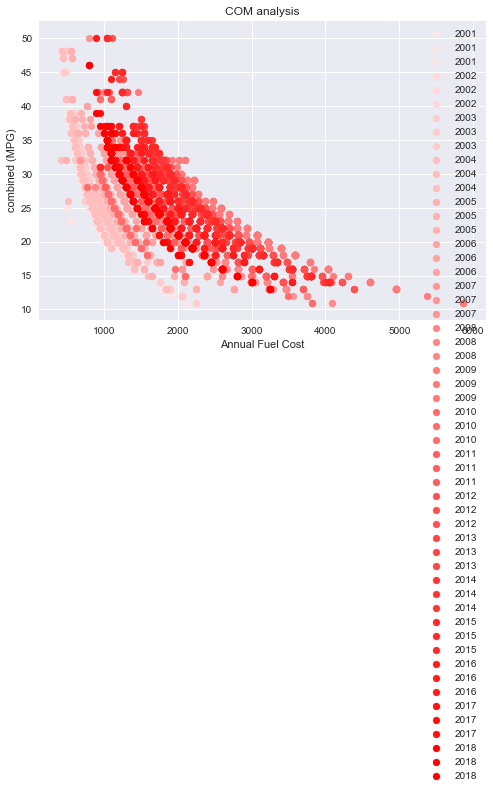

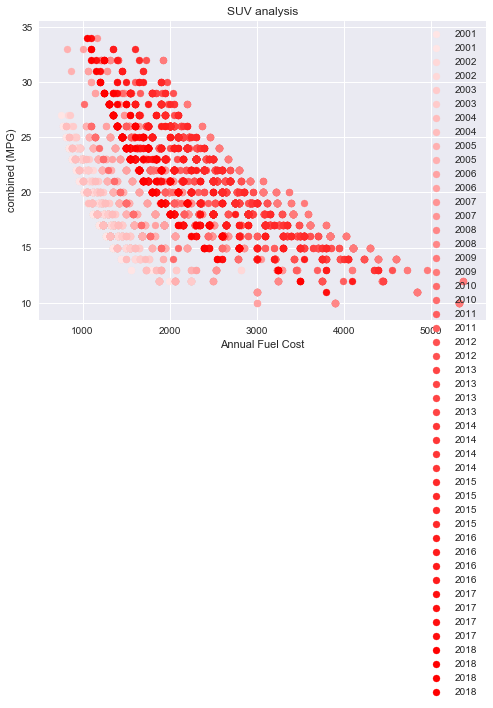

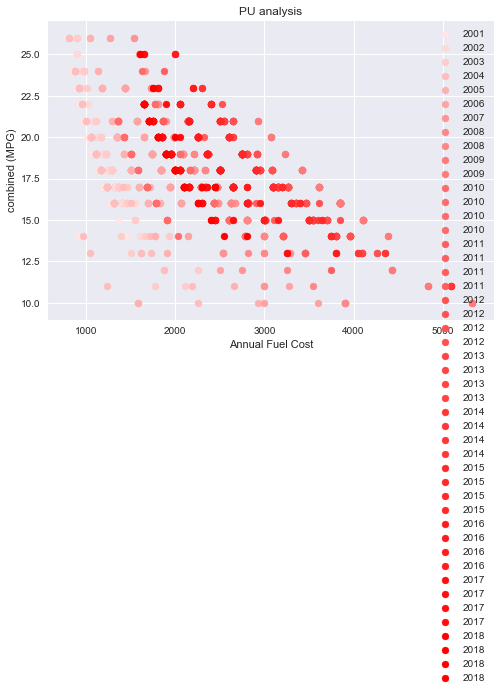

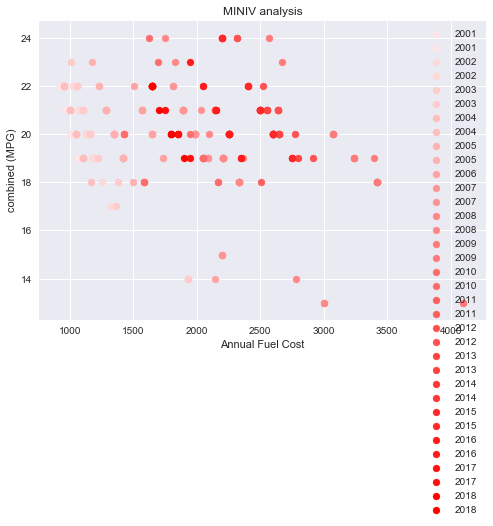

In [37]:
for t in classs:
    fig = plt.figure()
    plt.xlabel('Annual Fuel Cost')
    plt.ylabel('combined (MPG)')
    plt.title(t + ' analysis')
    for x in yearlst:
        curpd = pdfiles[x]
        s = set(curpd['Class'].values)
        for y in s:
            if y in carclass[t]:
                th = curpd[curpd['Class'] == y]
                i = th['fcost']
                j = th['cmb']
                plt.scatter(i,j, color = pir[int(x)-2001],label = x)

    plt.legend()
    plt.show()
    

In [28]:
# From the above plots, annual fuel cost has a clear relationship with 
# mileage per gallon. Lower fuel cost corresponds to higher mpg, while the 
# reverse happens for high annual fuel cost. Another observation is that 
# annual fuel cost increases over the late 00s and then decreases over the years.

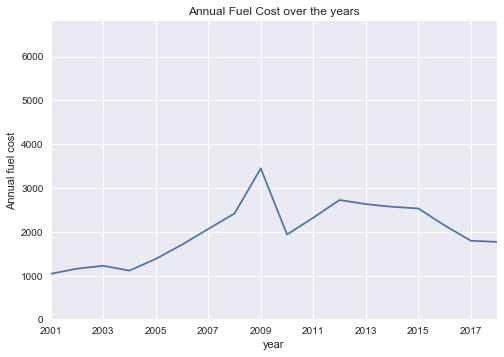

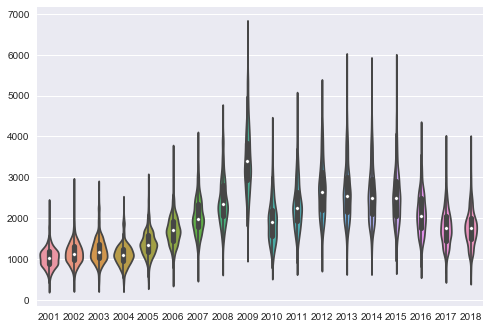

In [29]:
fig = plt.figure()
plt.xlabel('year')
plt.ylabel('Annual fuel cost')
plt.title('Annual Fuel Cost over the years')
byear = []
bcost = []
for x in yearlst:
    curpd = pdfiles[x]
    byear.extend(curpd['year'])
    bcost.extend(curpd['fcost'])
    
    plt.scatter(curpd['year'],curpd['fcost'])
b = pd.DataFrame(byear,columns=['year'])
b["cost"] = bcost

avg_lifeExp_per_interval = b.groupby('year').mean()
avg_lifeExp_per_interval.cost.plot()
plt.show()

sns.violinplot(y=bcost, x=byear)
plt.show()

In [30]:
# The above graph and violin plot shows the change in annual fuel cost over the years across all car 
# classes and car manufacturers. This may point to the fact that the annual fuel cost may have 
# underlying factors besides the car maker and car types. One potential source could be the inflation of 
# gas prices centered around 2009.  